## Problem 2 (50 points)

The square root diffusion process was first proposed by [Cox, Ingersoll, and Ross (1985)](https://www.sciencedirect.com/science/article/abs/pii/0304405X94900167) to model interest rates and has been quite popular for other uses. For example, it was applied by [Heston (2015)](https://academic.oup.com/rfs/article-abstract/6/2/327/1574747?redirectedFrom=fulltext&login=false) to model stochastic volatility in option pricing. The model is given by the following stochastic differential equation:

$$
d x_t = \kappa ( \theta - x_t ) dt + \sigma \sqrt{x_t} dZ_t
$$

where $x_t$ is the process level at time $t$, $\kappa$ is the mean-reversion factor, $\theta$ is the long term mean of the process, $\sigma$ is the constant volatility, and $Z$ is standard Brownian motion.

While it is well known that the values of $x_t$ are distributed chi-squared, it is often discretized and approximated using a normal distribution. This is what is known as the Euler discretization scheme (this is the general technique used in the course so far). The CIR process can be discretized (using the Euler scheme) as:  

$$
x_t = x_{t-1} + \kappa ( \theta - x_{t-1} ) \delta t + \sigma \sqrt{x_{t-1} \delta t} z_t
$$

In this case, the use of a normal distribution creates a slight problem. While the square-root diffusion requires that the values of $x_t$ be strictly positive, the use of the normal distribution produces both positive **and** negative values. In the simulation, this can be "fixed" two ways:
1. *Truncation method*: where we use $x^+ = \max(x,0)$:

$$
x_t = x_{t-1} + \kappa ( \theta - x_{t-1}^+ ) \delta t + \sigma \sqrt{x_{t-1}^+ \delta t} z_t
$$

2. *Reflection method*: where we use a positive value "as is" and "reflect" a negative value by changing the sign (alternatively, one could take an absolute value):

$$
x_t = \begin{cases}
x_{t-1} + \kappa ( \theta - x_{t-1} ) \delta t + \sigma \sqrt{x_{t-1} \delta t} z_t & \text{  if $>0$}\\
x_{t-1} + \kappa ( \theta - x_{t-1} ) \delta t - \sigma \sqrt{x_{t-1} \delta t} z_t & \text{  if $<0$}
\end{cases}
$$

There is a third method, the **exact** discretization scheme, based on the noncentral chi-squared distribution $\chi_d^2$, which can be written:

$$
x_t = \frac{\sigma^2 (1-e^{-\kappa \delta t})}{4 \kappa} 
\chi_d^2 \bigg( \frac{4 \kappa e^{-\kappa \delta t}}{\sigma^2(1-e^ {-\kappa \delta t})}x_{t-1} \bigg)
$$

where the noncentral parameter is in the parenthesis for the $\chi^2$ distribution, and the degrees of freedom are given by:

$$
d = \frac{4 \theta \kappa}{\sigma^2}
$$

(a) Develop the `python` code for each of these three methods and test the pricing using the parameters $T=1$, $x_0 = 0.1$, $\kappa = 0.5$, $\theta = 0.1$, and $\sigma = 0.8$ (reporting the errors with each). You want to make sure that you are comparing apples-to-apples: same seed (=2), same parameters, same number of time periods, and same number of paths.
(b) Plot the time series of the truncated value against the reflecting value. Do you have any observations?
(c) Compute the cost of running each of the methods and compare. Which is better and why?

I used code from the Stochastic Calculus class (path_sim) that I adjusted

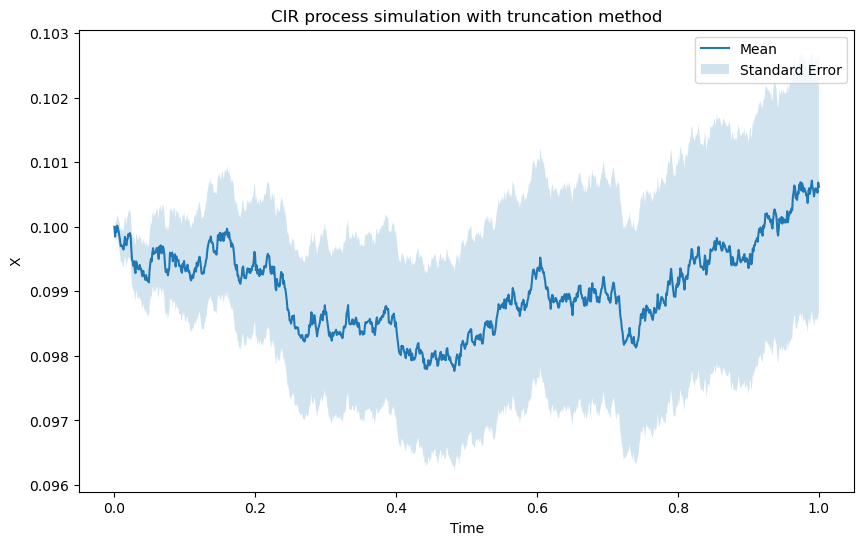

In [161]:
T = 1
x0 = 0.1
kappa = 0.5
theta = 0.1
sigma = 0.8
N = 10000
dt = 0.001

rng = default_rng(seed=2)
np.random.seed(2)

# -------------------- The simulator, Create OU paths using EM  --------------------


def path_sim(X0=x0, n=N, dt=dt, T=T, rng=rng):

    nT = T / dt  #  "number" of time steps, but may not be an integer
    nT = int(nT + 1)  #  round up to the nearest integer, the number of time steps
    dt = T / nT  #  adjust the time step down accordingly

    T = np.linspace(0.0, T, nT + 1)  # steps of size dt between 0 and T,
    # including 0 and T
    X = np.zeros((n, (nT + 1)), np.float64)  #  allocate path array
    for i in range(n):
        X[i, 0] = X0
    for k in range(nT):  # take a time step for all n paths at once

        X[:, k + 1] = (
            X[:, k]
            + kappa * (theta - np.maximum(0, X[:, k])) * dt
            + np.random.normal(size=n) * sigma * np.sqrt(dt * np.maximum(0, X[:, k]))
        )

    return (X, T)


X, Time = path_sim()
mean_X = np.mean(X, axis=0)
std_X = np.std(X, axis=0) / np.sqrt(N)

plt.figure(figsize=(10, 6))
plt.plot(Time, mean_X, label="Mean")
plt.fill_between(
    Time, mean_X - std_X, mean_X + std_X, alpha=0.2, label="Standard Error"
)
plt.legend()
plt.xlabel("Time")
plt.ylabel("X")
plt.title("CIR process simulation with truncation method")
plt.show()

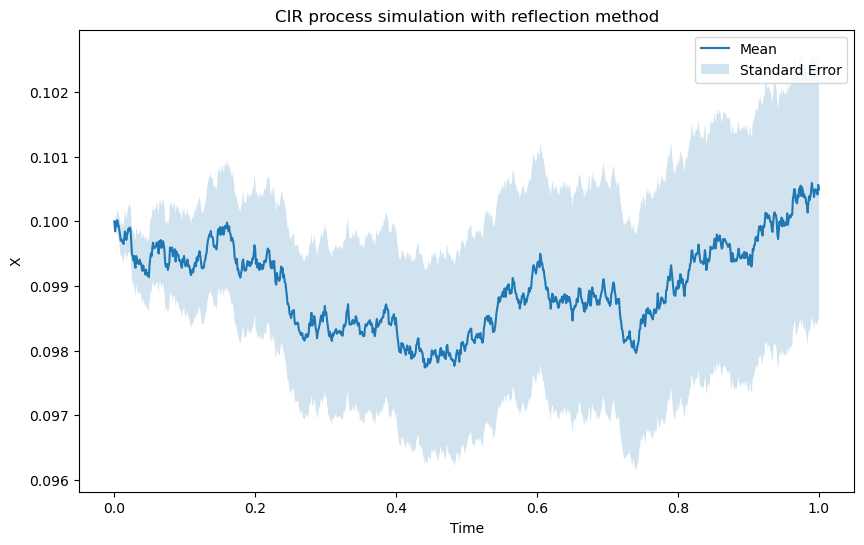

In [162]:
rng = default_rng(seed=2)
np.random.seed(2)


def path_sim2(X0=x0, n=N, dt=dt, T=T, rng=rng):

    nT = T / dt  #  "number" of time steps, but may not be an integer
    nT = int(nT + 1)  #  round up to the nearest integer, the number of time steps
    dt = T / nT  #  adjust the time step down accordingly

    T = np.linspace(0.0, T, nT + 1)  # steps of size dt between 0 and T,
    # including 0 and T
    X = np.zeros((n, (nT + 1)), np.float64)  #  allocate path array
    for i in range(n):
        X[i, 0] = X0
    for k in range(nT):  # take a time step for all n paths at once

        X[:, k + 1] = (
            X[:, k]
            + kappa * (theta - X[:, k]) * dt
            + np.random.normal(size=n) * sigma * np.sqrt(dt * np.abs(X[:, k]))
        )

    return (X, T)


X2, Time2 = path_sim2()
mean_X2 = np.mean(X2, axis=0)
std_X2 = np.std(X2, axis=0) / np.sqrt(N)

plt.figure(figsize=(10, 6))
plt.plot(Time2, mean_X2, label="Mean")
plt.fill_between(
    Time2, mean_X2 - std_X2, mean_X2 + std_X2, alpha=0.2, label="Standard Error"
)
plt.legend()
plt.xlabel("Time")
plt.ylabel("X")
plt.title("CIR process simulation with reflection method")
plt.show()

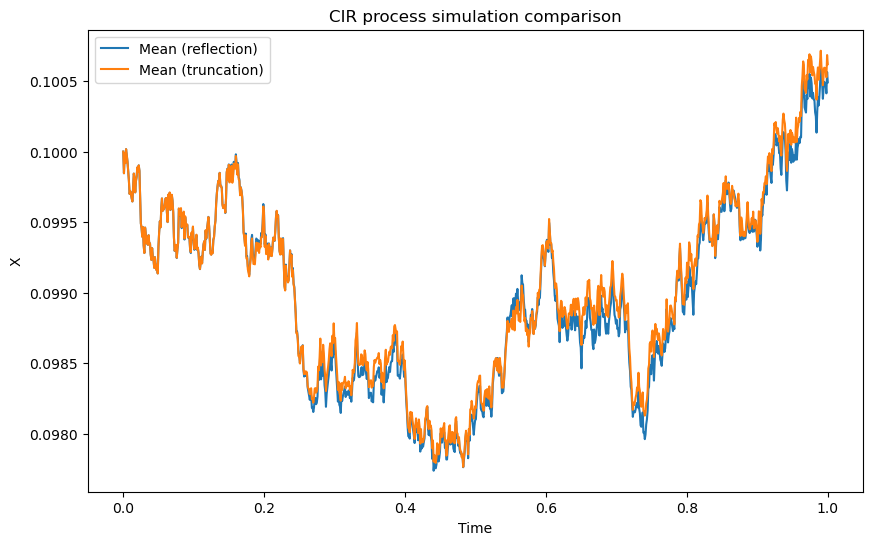

In [163]:
plt.figure(figsize=(10, 6))
plt.plot(Time2, mean_X2, label="Mean (reflection)")
plt.plot(Time, mean_X, label="Mean (truncation)")
plt.legend()
plt.xlabel("Time")
plt.ylabel("X")
plt.title("CIR process simulation comparison")
plt.show()

The two methods give extremely similar results, but seem to diverge as time goes on probably because the differences in the two approximations become more significant

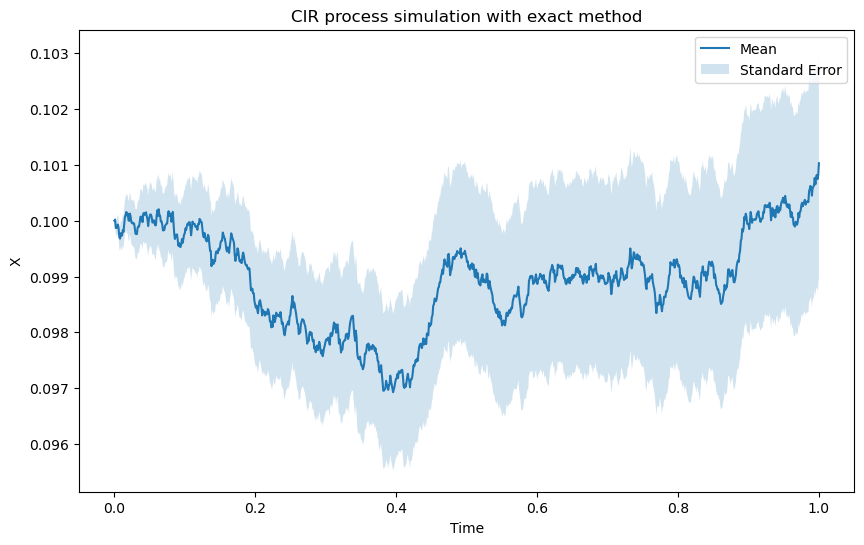

In [164]:
np.random.seed(2)


def path_sim3(X0=x0, n=N, dt=dt, T=T, rng=rng):

    nT = T / dt  #  "number" of time steps, but may not be an integer
    nT = int(nT + 1)  #  round up to the nearest integer, the number of time steps
    dt = T / nT  #  adjust the time step down accordingly

    T = np.linspace(0.0, T, nT + 1)  # steps of size dt between 0 and T,
    # including 0 and T
    X = np.zeros((n, (nT + 1)), np.float64)  #  allocate path array
    for i in range(n):
        X[i, 0] = X0
    for k in range(nT):  # take a time step for all n paths at once

        d = (4 * theta * kappa) / (sigma**2)
        nonc = (
            (4 * kappa * np.exp(-kappa * dt))
            / (sigma**2 * (1 - np.exp(-kappa * dt)))
            * X[:, k]
        )
        X[:, k + 1] = (
            sigma**2 * (1 - np.exp(-kappa * dt)) / (4 * kappa)
        ) * np.random.noncentral_chisquare(d, nonc, size=n)

    return (X, T)


X3, Time3 = path_sim3()
mean_X3 = np.mean(X3, axis=0)
std_X3 = np.std(X3, axis=0) / np.sqrt(N)

plt.figure(figsize=(10, 6))
plt.plot(Time3, mean_X3, label="Mean")
plt.fill_between(
    Time3, mean_X3 - std_X3, mean_X3 + std_X3, alpha=0.2, label="Standard Error"
)
plt.legend()
plt.xlabel("Time")
plt.ylabel("X")
plt.title("CIR process simulation with exact method")
plt.show()

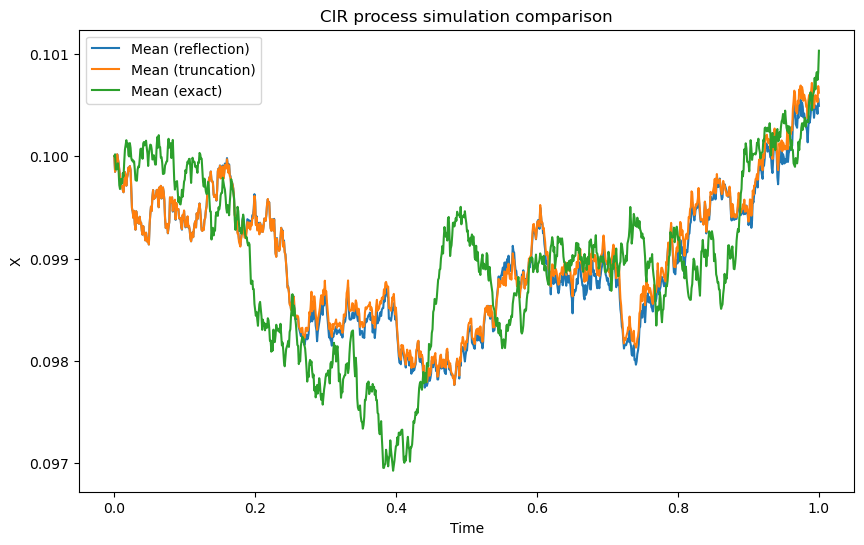

In [165]:
plt.figure(figsize=(10, 6))
plt.plot(Time2, mean_X2, label="Mean (reflection)")
plt.plot(Time, mean_X, label="Mean (truncation)")
plt.plot(Time3, mean_X3, label="Mean (exact)")
plt.legend()
plt.xlabel("Time")
plt.ylabel("X")
plt.title("CIR process simulation comparison")
plt.show()

final comparison

Not much to say, the exact method does not give the same result than the approximations methods for the same seed. However in average the processes should be the same

In [157]:
%timeit _,_ = path_sim()
%timeit _,_ = path_sim2()
%timeit _,_ = path_sim3()

444 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
432 ms ± 5.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.3 s ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The truncation and reflection method have more or less the same speed whil the exact method is much slower (2-3x)

This is expected since the exact method is more complex and requires more computations. The approximations methods require very litle additional computation (max or abs), while the exact method increases the number of operations to perform, require exponentials and draw from the chi squared distribution instead of the normal distribution which I suspect to be slower, lets verify that:

In [158]:
%timeit np.random.noncentral_chisquare(3, 2, size=10)
%timeit np.random.normal(size=10)

3.05 µs ± 17.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
2.79 µs ± 58.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The difference is not very important, then it must be the additionnal operations that make the exact method slower.